
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [1]:
# !pip install pyLDAvis 

In [2]:
# import libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

In [3]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


####   Dataset Analysis

In [4]:
# Read data from csv
customer_review_data= pd.read_csv("amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [5]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [6]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madhushanihewagama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 

####   Filter short reviews according to rating

In [8]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=20)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
640


In [9]:
df_short_reviews

,rating,date,variation,verified_reviews,feedback,Num_words_text
2,4,31-Jul-18,Walnut Finish,sometimes while playing game answer question c...,1,21
6,3,31-Jul-18,Sandstone Fabric,without having cellphone cannot many features ...,1,33
7,5,31-Jul-18,Charcoal Fabric,think this purchased working getting every roo...,1,22
12,5,30-Jul-18,Oak Finish,purchased this mother having knee problems giv...,1,30
17,5,30-Jul-18,Heather Gray Fabric,have only been using alexa couple days having ...,1,21
...,...,...,...,...,...,...
3101,5,30-Jul-18,Black Dot,these additional alexa based devices make acce...,1,27
3110,5,30-Jul-18,White Dot,love personally prefer spotify music it’s grea...,1,46
3129,4,30-Jul-18,White Dot,have these throughout home they great there ti...,1,38
3147,5,30-Jul-18,Black Dot,love these things have them running entire hom...,1,49


In [10]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,30-Jul-18,White Dot,having real difficulty working with echo alexi...,0,32
1,1,13-Jul-18,Black,wanted these radio intercom terrible reception...,0,59
2,1,30-Jul-18,Black Dot,reached amazon because device wanted sync phon...,0,34
3,1,12-Jun-18,Black,stopped working after months warranty only goo...,0,40
4,1,22-Jul-18,Black Spot,these amazon ignoring customers using these de...,0,48
...,...,...,...,...,...,...
195,5,28-Jul-18,Black Show,still learning have just started integrating s...,1,27
196,5,30-Jul-18,Configuration: Fire TV Stick,dont have alexa after getting this feeling ins...,1,36
197,5,29-Jul-18,Charcoal Fabric,bought echo dots repeated take hers because gr...,1,47
198,5,19-Jul-18,Black Spot,echo spot really helped streamline more effici...,1,21


####   Dataset Pre-processing

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [12]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

#### Finding Nouns and Adjectives

In [13]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

wanted radio intercom terrible reception live speech recognition software horrible wife native americans whose language english north texas neither accent birth area good understanding bought thing additionally wifi reception poor marginal wifi range extender office feet router problems switched around difference disconnected dust collectors
['radio', 'intercom', 'terrible', 'reception', 'live', 'speech', 'recognition', 'software', 'horrible', 'wife', 'native', 'language', 'accent', 'birth', 'area', 'good', 'understanding', 'thing', 'reception', 'poor', 'marginal', 'wifi', 'range', 'extender', 'office', 'foot', 'router', 'problem', 'difference', 'disconnected', 'dust', 'collector']


#### Dictionary and Document term matrix

In [14]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [16]:
# Build LDA model
num_topics=40
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=10,
                chunksize=100, passes=50,iterations=100)

In [17]:
lda_model.print_topics(num_topics)

[(0,
  '0.075*"setup" + 0.053*"alarm" + 0.045*"many" + 0.040*"easy" + 0.038*"screen" + 0.036*"alexa" + 0.024*"several" + 0.024*"install" + 0.023*"simple" + 0.020*"home"'),
 (1,
  '0.109*"alexa" + 0.071*"part" + 0.063*"bedside" + 0.060*"ability" + 0.054*"instruction" + 0.050*"search" + 0.038*"clock" + 0.037*"music" + 0.035*"computer" + 0.035*"variety"'),
 (2,
  '0.070*"account" + 0.064*"device" + 0.049*"bluetooth" + 0.039*"echo" + 0.036*"manual" + 0.036*"personal" + 0.035*"membership" + 0.026*"respond" + 0.024*"star" + 0.024*"system"'),
 (3,
  '0.001*"equipment" + 0.001*"connectivity" + 0.001*"kid" + 0.001*"wellgood" + 0.001*"interact" + 0.001*"fast" + 0.001*"song" + 0.001*"dictionary" + 0.001*"player" + 0.001*"accessneed"'),
 (4,
  '0.117*"item" + 0.075*"purchase" + 0.060*"next" + 0.053*"work" + 0.044*"blue" + 0.044*"ready" + 0.042*"connect" + 0.042*"button" + 0.028*"echo" + 0.027*"light"'),
 (5,
  '0.061*"device" + 0.044*"echo" + 0.032*"home" + 0.030*"wifi" + 0.029*"problem" + 0.026*"

#### Measureing the model

In [18]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -13.323438934099208

Coherence Score: 0.47675713107460094


#### Visualize the topics

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is de

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23    -0.206371  0.126300       1        1  9.017238
35    -0.110792 -0.182630       2        1  5.961278
28    -0.217377  0.121033       3        1  5.769040
11     0.009510 -0.150893       4        1  4.812984
5     -0.159133 -0.141213       5        1  4.628647
20    -0.122665  0.034159       6        1  4.583237
33    -0.137387  0.058570       7        1  4.539470
32    -0.086867 -0.115061       8        1  4.269054
15    -0.065119  0.010336       9        1  4.124432
0     -0.115034  0.072190      10        1  4.018645
1     -0.005865  0.152134      11        1  3.757806
13    -0.083860  0.037788      12        1  3.620414
18    -0.145585 -0.128813      13        1  3.357278
31    -0.080981 -0.050340      14        1  2.662705
10    -0.006280 -0.011857      15        1  2.348664
2     -0.018840 -0.055368      16        1  2.322400
25     0.015864  0.035211      17        1  2.279656
39     0.002213  0.146166      18        1  2.258917
27     0.063963 -0.028464      19        1  2.128876
14     0.043480  0.069578      20        1  2.090389
36     0.029365  0.088631      21        1  1.916288
12     0.068970 -0.091692      22        1  1.887542
4      0.049037 -0.078510      23        1  1.707418
22     0.024488 -0.012213      24        1  1.655523
17     0.089709 -0.095770      25        1  1.450543
9      0.040319 -0.054236      26        1  1.447422
21     0.062837  0.017847      27        1  1.444179
34     0.080496  0.071099      28        1  1.421817
38     0.068911 -0.005534      29        1  1.329331
24     0.046476  0.100782      30        1  1.281404
16     0.045670 -0.044355      31        1  1.208371
7      0.066328 -0.007606      32        1  1.009766
29     0.120646  0.016247      33        1  0.836496
19     0.085751  0.053038      34        1  0.833804
37     0.070907  0.010727      35        1  0.731287
6      0.114151  0.006099      36        1  0.576471
26     0.090766  0.006655      37        1  0.177802
30     0.090766  0.006655      38        1  0.177802
3      0.090766  0.006655      39        1  0.177802
8      0.090766  0.006655      40        1  0.177802, topic_info=         Term       Freq      Total Category  logprob  loglift
5       great  36.000000  36.000000  Default  30.0000  30.0000
7       music  74.000000  74.000000  Default  29.0000  29.0000
49     device  79.000000  79.000000  Default  28.0000  28.0000
139      echo  52.000000  52.000000  Default  27.0000  27.0000
169     sound  37.000000  37.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
25   language   0.005699   5.379309  Topic40  -6.8916  -0.5178
26       live   0.005699   1.550856  Topic40  -6.8916   0.7260
27   marginal   0.005699   1.550856  Topic40  -6.8916   0.7260
28     native   0.005699   1.550856  Topic40  -6.8916   0.7260
29     office   0.005699   3.395748  Topic40  -6.8916  -0.0577

[1796 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
310       5  0.618286   1030pm
0        20  0.780992     34im
351       4  0.608423    34the
334      10  0.604679  34thing
111      10  0.453769    34try
...     ...       ...      ...
208       1  0.872717  youtube
208       7  0.087272  youtube
374       1  0.571803   zigbee
384      15  0.650278    zwave
201       7  0.618877     zzzz

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 36, 29, 12, 6, 21, 34, 33, 16, 1, 2, 14, 19, 32, 11, 3, 26, 40, 28, 15, 37, 13, 5, 23, 18, 10, 22, 35, 39, 25, 17, 8, 30, 20, 38, 7, 27, 31, 4, 9])

#### Finding the best model 

In [20]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

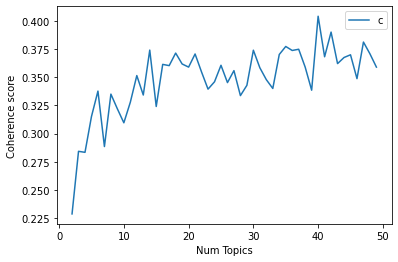

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [23]:
# Print the coherence scores
max_coherence=0
optimal_topics=0
index_model=0
i=0
for m, cv in zip(x, coherence_values):
    if(max_coherence<cv):
        index_model=i
        max_coherence=cv
        optimal_topics=m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i+=1
    
print("\n_____________________________________________________")   
print(index_model," :: "+"Optimal Topic number =", optimal_topics, " Coherence Scores =", round(max_coherence, 4))

Num Topics = 2  has Coherence Value of 0.2288
Num Topics = 3  has Coherence Value of 0.2843
Num Topics = 4  has Coherence Value of 0.2834
Num Topics = 5  has Coherence Value of 0.3151
Num Topics = 6  has Coherence Value of 0.3377
Num Topics = 7  has Coherence Value of 0.2885
Num Topics = 8  has Coherence Value of 0.335
Num Topics = 9  has Coherence Value of 0.3219
Num Topics = 10  has Coherence Value of 0.3096
Num Topics = 11  has Coherence Value of 0.3278
Num Topics = 12  has Coherence Value of 0.3515
Num Topics = 13  has Coherence Value of 0.3342
Num Topics = 14  has Coherence Value of 0.3741
Num Topics = 15  has Coherence Value of 0.324
Num Topics = 16  has Coherence Value of 0.3614
Num Topics = 17  has Coherence Value of 0.3603
Num Topics = 18  has Coherence Value of 0.3714
Num Topics = 19  has Coherence Value of 0.3618
Num Topics = 20  has Coherence Value of 0.359
Num Topics = 21  has Coherence Value of 0.3706
Num Topics = 22  has Coherence Value of 0.3546
Num Topics = 23  has Coh

In [24]:
# Select the model and print the topics
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(2,
  '0.030*"face" + 0.030*"card" + 0.025*"dot" + 0.024*"tall" + 0.023*"volume" + 0.020*"product" + 0.019*"wall" + 0.016*"speaker" + 0.015*"great" + 0.015*"star"'),
 (22,
  '0.036*"literate" + 0.036*"month" + 0.024*"alexa" + 0.024*"product" + 0.024*"beginner" + 0.016*"time" + 0.014*"whole" + 0.012*"mode" + 0.012*"basic" + 0.012*"slow"'),
 (30,
  '0.033*"echo" + 0.030*"number" + 0.030*"phone" + 0.024*"access" + 0.021*"speaker" + 0.020*"small" + 0.020*"great" + 0.020*"device" + 0.017*"quality" + 0.017*"amazon"'),
 (17,
  '0.018*"volume" + 0.014*"tall" + 0.013*"dot" + 0.010*"speaker" + 0.009*"awesome" + 0.009*"connected" + 0.009*"room" + 0.009*"voice" + 0.007*"connect" + 0.007*"low"'),
 (6,
  '0.062*"device" + 0.017*"time" + 0.017*"half" + 0.017*"connect" + 0.017*"skill" + 0.017*"sure34" + 0.017*"question" + 0.017*"thing" + 0.017*"content" + 0.017*"music"'),
 (36,
  '0.032*"alexa" + 0.032*"internet" + 0.024*"trouble" + 0.024*"device" + 0.024*"connection" + 0.022*"echo" + 0.021*"issue" +

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is de

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20    -0.108766  0.049307       1        1  5.522906
14    -0.118906 -0.085749       2        1  4.981062
38    -0.074681 -0.072562       3        1  4.794541
5     -0.055277  0.063818       4        1  4.501704
30    -0.098134 -0.052938       5        1  4.196707
3      0.045158 -0.048567       6        1  3.808140
29    -0.071366 -0.030194       7        1  3.554099
4     -0.109966 -0.088106       8        1  3.553971
35    -0.092972  0.008540       9        1  3.361375
16    -0.027317 -0.039274      10        1  3.293840
13    -0.090015  0.110036      11        1  3.265630
31     0.120097  0.076981      12        1  3.101874
11     0.011015 -0.159370      13        1  3.057674
36    -0.063767  0.093689      14        1  3.040341
24    -0.038969  0.120256      15        1  2.949439
15    -0.014557 -0.062912      16        1  2.760156
21    -0.039296 -0.050789      17        1  2.738341
6     -0.063208  0.051258      18        1  2.665374
0     -0.081599  0.070790      19        1  2.534952
7     -0.090115  0.000325      20        1  2.422913
8     -0.073454  0.060400      21        1  2.401927
34    -0.042085 -0.036328      22        1  2.386901
26     0.103484  0.032127      23        1  2.385853
9      0.003722 -0.004645      24        1  2.280848
18    -0.040472  0.029347      25        1  2.018285
27     0.112873  0.101755      26        1  1.962564
19     0.090523 -0.062995      27        1  1.840336
22     0.132794 -0.047248      28        1  1.832890
37     0.043751  0.016418      29        1  1.808566
1      0.065739  0.016495      30        1  1.555031
23     0.031418 -0.033054      31        1  1.492469
32     0.027617  0.071263      32        1  1.358076
2      0.056082 -0.067648      33        1  1.354367
33     0.072953  0.038877      34        1  1.203146
28     0.057880  0.066759      35        1  1.074450
10     0.049335 -0.050291      36        1  1.035347
39     0.065186 -0.118712      37        1  0.940347
12     0.110572 -0.005177      38        1  0.566870
25     0.101698  0.028563      39        1  0.250158
17     0.093025  0.009554      40        1  0.146529, topic_info=         Term       Freq      Total Category  logprob  loglift
49     device  68.000000  68.000000  Default  30.0000  30.0000
169     sound  32.000000  32.000000  Default  29.0000  29.0000
121      spot  17.000000  17.000000  Default  28.0000  28.0000
7       music  58.000000  58.000000  Default  27.0000  27.0000
139      echo  45.000000  45.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
8    question   0.004046  13.154760  Topic40  -7.0407  -1.5610
9        real   0.004046   3.141058  Topic40  -7.0407  -0.1288
10      smart   0.004046  13.345630  Topic40  -7.0407  -1.5754
11     sure34   0.004046   3.943184  Topic40  -7.0407  -0.3562
12       time   0.004046  33.088157  Topic40  -7.0407  -2.4834

[1895 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
310      20  0.726089   1030pm
856      30  0.692729    34hmm
0         6  0.507223     34im
0        18  0.253612     34im
351      12  0.659465    34the
...     ...       ...      ...
208      11  0.117846  youtube
208      32  0.117846  youtube
374       2  0.654740   zigbee
384      17  0.623898    zwave
201       8  0.718062     zzzz

[2235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 15, 39, 6, 31, 4, 30, 5, 36, 17, 14, 32, 12, 37, 25, 16, 22, 7, 1, 8, 9, 35, 27, 10, 19, 28, 20, 23, 38, 2, 24, 33, 3, 34, 29, 11, 40, 13, 26, 18])

#### Predict new review using trained model

In [26]:
# Enter customer review
input_review="I was a little nervous when I received my new Echo as I'm not really Tech savvy. I found it a bit intimidating at first but it didn't take me to long to figure it out!! I'm very happy with my purchase and now thinking of adding an echo spot!!!"

In [27]:
# Predicting the topic distribution for the given review
input_testing_review_list=[""]
input_testing_review_list[0]=input_review
tokenized_testing_reviews = lemmatization(input_testing_review_list)
# print(tokenized_testing_reviews[0])

# Tokenized_testing_reviews
new_doc_bow = dictionary.doc2bow(tokenized_testing_reviews[0])
predict_list=lda_model.get_document_topics(new_doc_bow)
predict_list

[(15, 0.2962422), (17, 0.27885488), (18, 0.14989284), (36, 0.14643203)]

In [28]:
# Finding predict topic
predict_topic_id=0
predict_probability=0

for topic in predict_list:
    if(predict_probability<topic[1]):
        predict_topic_id=topic[0]
        predict_probability=topic[1]
        
#Topic_id ,Probability
print("Topic_id =",predict_topic_id,"  Probability =",predict_probability)

Topic_id = 15   Probability = 0.2962422


#### All topics labels

In [29]:
# find all topic labels
x=lda_model.show_topics(num_topics=num_topics, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
topic_label_list_all=[]
#Below Code Prints Only Words 
for topic,words in topics_words:
    topic_label_list_all.append(" ".join(words))

In [30]:
topic_label_list_all

['setup alarm many easy screen alexa several install simple home',
 'alexa part bedside ability instruction search clock music computer variety',
 'account device bluetooth echo manual personal membership respond star system',
 'equipment connectivity kid wellgood interact fast song dictionary player accessneed',
 'item purchase next work blue ready connect button echo light',
 'device echo home wifi problem original night well audio thing',
 'conversation news weary picking prevent firmware push widespread development major',
 'different screen present talk sure work video turn camera audio',
 'equipment connectivity kid wellgood interact fast song dictionary player accessneed',
 'issue internet connection echo fine timer line reminder screen show',
 'good time channel response week hour thing work email reset',
 'list app echo time hard radio long decrease volume increase',
 'echo compatible door system enough question choice research work lock',
 'alexa device issue spotify impresse

In [31]:
# # access train model to predict Neg and Pos
# %cd ./Customer_reviews_classification(Pos&Neg).ipynb


In [32]:
# pos_count=0
# neg_count=0
# final_topic_label_list_all=[]

# for k in topic_label_list_all:
#     y_pred=clf.predict(count_vectorizer.transform([k]))
#     if(y_pred[0]==1):
#         pos_count+=1
#         final_topic_label_list_all.append(k+' -- POSITIVE')
#     else:
#         neg_count+=1
#         final_topic_label_list_all.append(k+' -- NEGATIVE')
    

In [33]:
# # Printing all labels
# for (i, item) in enumerate(final_topic_label_list_all, start=1):
#     print("Topic",i,"::",item)

In [34]:
# #positive topics
# print("Number of Positive topics =",pos_count)

In [35]:
# #negative topics
# print("Number of Negative topics =",neg_count)